In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from cStringIO import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time

import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

In [2]:
model = "dualPowerLaw"
period_rng = (50, 400)
n_period = 57
rp_rng = (0.75, 2.5)
n_rp = 61



In [3]:
def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]


def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) +"^{+" + "{:.3f}".format(e[1]) + "}_{-" + "{:.3f}".format(e[2]) + "}"



In [4]:
from scipy.integrate import romb

def integrate2DGrid(g, dx, dy):
    if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
        raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return romb(romb(g, dx), dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 2**5+1 # must be 2**n + 1
    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nPts), 
                                       np.linspace(rpRange[0], rpRange[1], nPts), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret


def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nP), 
                                       np.linspace(rpRange[0], rpRange[1], nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)





In [5]:

def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))
    elif model == "dualPowerLawGap":
        f0, alpha, beta, gd, gw, gapOffset, gapSlope = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
#        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawGapFixedSlope":
        f0, alpha, beta, gd, gw, gapOffset = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawFixedValley":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gd = 0.29297043
        gw = 0.14683756
        gapSlope = 0
        gapOffset = 0.29125824

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    else:
        raise ValueError('Bad model name');
        
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    elif model == "dualPowerLawGap":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$", r"$s_g$"]
    elif model == "dualPowerLawGapFixedSlope":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$"]
    elif model == "dualPowerLawFixedValley":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    elif model == "dualPowerLawGap":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        gs = 0.0
        theta = [f0, alpha, beta, gd, gw, go, gs]
    elif model == "dualPowerLawGapFixedSlope":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        theta = [f0, alpha, beta, gd, gw, go]
    elif model == "dualPowerLawFixedValley":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    else:
        raise ValueError('Bad model name');
  
    return theta


In [6]:
HB1PosteriorsNoReliability = np.load("highBox1Output/occurenceRatePosteriors_noreliability.npy")
HB1PosteriorsWithReliability = np.load("highBox1Output/occurenceRatePosteriors.npy")

LB1PosteriorsNoReliability = np.load("lowBox1Output/occurenceRatePosteriors_noreliability.npy")
LB1PosteriorsWithReliability = np.load("lowBox1Output/occurenceRatePosteriors.npy")

HB2PosteriorsNoReliability = np.load("highBox2Output/occurenceRatePosteriors_noreliability.npy")
HB2PosteriorsWithReliability = np.load("highBox2Output/occurenceRatePosteriors.npy")

LB2PosteriorsNoReliability = np.load("lowBox2Output/occurenceRatePosteriors_noreliability.npy")
LB2PosteriorsWithReliability = np.load("lowBox2Output/occurenceRatePosteriors.npy")

basePosteriorsNoReliability = np.load("baselineFpwgpcOutput/occurenceRatePosteriors_noreliability.npy")
basePosteriorsWithReliability = np.load("baselineFpwgpcOutput/occurenceRatePosteriors.npy")



In [7]:
print("F_0 High Box 1 Without Reliability = " + printMedianAndErrorbars(HB1PosteriorsNoReliability[:,0]))
print("F_0 High Box 1 With Reliability = " + printMedianAndErrorbars(HB1PosteriorsWithReliability[:,0]))

print("F_0 Low Box 1 Without Reliability = " + printMedianAndErrorbars(LB1PosteriorsNoReliability[:,0]))
print("F_0 Low Box 1 With Reliability = " + printMedianAndErrorbars(LB1PosteriorsWithReliability[:,0]))

print("F_0 High Box 2 Without Reliability = " + printMedianAndErrorbars(HB2PosteriorsNoReliability[:,0]))
print("F_0 High Box 2 With Reliability = " + printMedianAndErrorbars(HB2PosteriorsWithReliability[:,0]))

print("F_0 Low Box 2 Without Reliability = " + printMedianAndErrorbars(LB2PosteriorsNoReliability[:,0]))
print("F_0 Low Box 2 With Reliability = " + printMedianAndErrorbars(LB2PosteriorsWithReliability[:,0]))

print("F_0 fpwgpc baseline Without Reliability = " + printMedianAndErrorbars(basePosteriorsNoReliability[:,0]))
print("F_0 fpwgpc baseline With Reliability = " + printMedianAndErrorbars(basePosteriorsWithReliability[:,0]))


F_0 High Box 1 Without Reliability = 1.231^{+0.219}_{-0.183}
F_0 High Box 1 With Reliability = 0.583^{+0.121}_{-0.098}
F_0 Low Box 1 Without Reliability = 0.962^{+0.206}_{-0.165}
F_0 Low Box 1 With Reliability = 0.510^{+0.130}_{-0.100}
F_0 High Box 2 Without Reliability = 0.971^{+0.188}_{-0.149}
F_0 High Box 2 With Reliability = 0.408^{+0.090}_{-0.072}
F_0 Low Box 2 Without Reliability = 0.937^{+0.200}_{-0.162}
F_0 Low Box 2 With Reliability = 0.552^{+0.143}_{-0.113}
F_0 fpwgpc baseline Without Reliability = 0.886^{+0.164}_{-0.131}
F_0 fpwgpc baseline With Reliability = 0.463^{+0.098}_{-0.079}


In [8]:
capsize = 8
cbc = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']



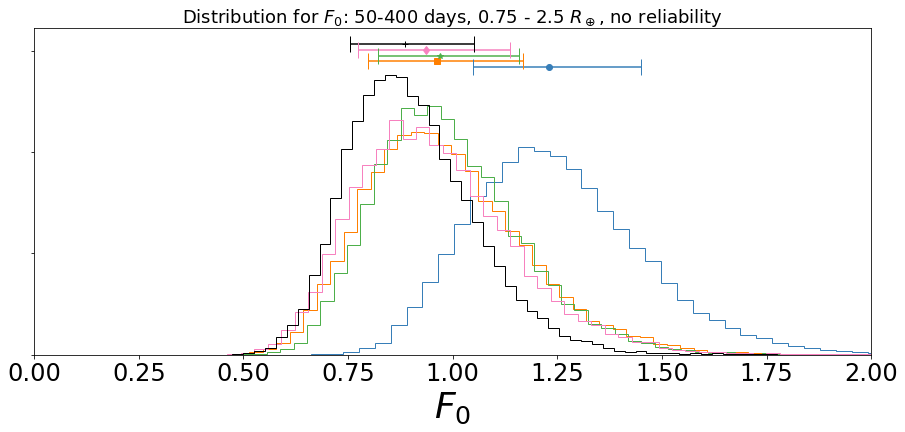

In [9]:
plt.figure(figsize=(15,6));
plt.hist(HB1PosteriorsNoReliability[:,0], 50, histtype="step", color=cbc[0], density=True);
plt.hist(LB1PosteriorsNoReliability[:,0], 50, histtype="step", color=cbc[1], density=True);
plt.hist(HB2PosteriorsNoReliability[:,0], 50, histtype="step", color=cbc[2], density=True);
plt.hist(LB2PosteriorsNoReliability[:,0], 50, histtype="step", color=cbc[3], density=True);
plt.hist(basePosteriorsNoReliability[:,0], 50, histtype="step", color='k', density=True);
plt.xlim(0, 2.0)
ylim = plt.ylim()
HB1NrStats = medianAndErrorbars(HB1PosteriorsNoReliability[:,0])
LB1NrStats = medianAndErrorbars(LB1PosteriorsNoReliability[:,0])
HB2NrStats = medianAndErrorbars(HB2PosteriorsNoReliability[:,0])
LB2NrStats = medianAndErrorbars(LB2PosteriorsNoReliability[:,0])
baseNrStats = medianAndErrorbars(basePosteriorsNoReliability[:,0])
plt.errorbar(HB1NrStats[0], 0.98*ylim[1], xerr=[[HB1NrStats[2]],[HB1NrStats[1]]], capsize = capsize, color = cbc[0], fmt='--o')
plt.errorbar(LB1NrStats[0], 1.0*ylim[1], xerr=[[LB1NrStats[2]],[LB1NrStats[1]]], capsize = capsize, color = cbc[1], fmt='--s')
plt.errorbar(HB2NrStats[0], 1.02*ylim[1], xerr=[[HB2NrStats[2]],[HB2NrStats[1]]], capsize = capsize, color = cbc[2], fmt='--*')
plt.errorbar(LB2NrStats[0], 1.04*ylim[1], xerr=[[LB2NrStats[2]],[LB2NrStats[1]]], capsize = capsize, color = cbc[3], fmt='--d')
plt.errorbar(baseNrStats[0], 1.06*ylim[1], xerr=[[baseNrStats[2]],[baseNrStats[1]]], capsize = capsize, color = "k", fmt='--+')
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel(r"$F_0$", fontSize = 36);
plt.savefig("bootstrapComparison/f0DistNoReliability.pdf",bbox_inches='tight')
plt.title("Distribution for $F_0$: 50-400 days, 0.75 - 2.5 $R_\oplus$, no reliability", fontsize=18);


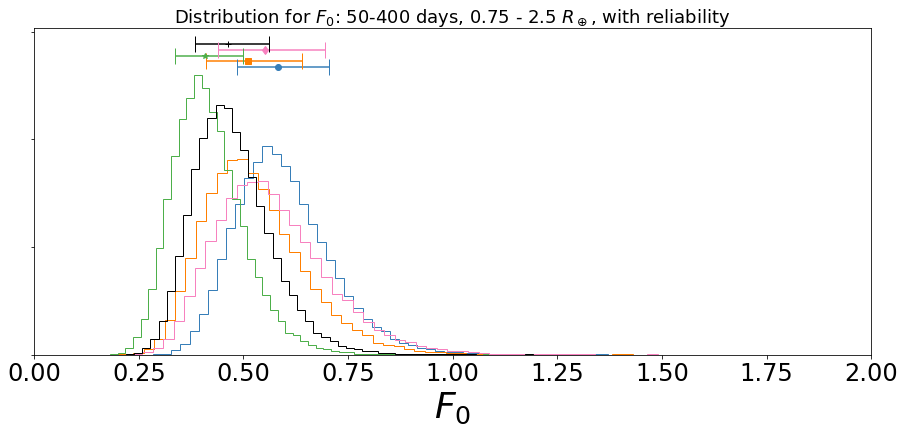

In [10]:
plt.figure(figsize=(15,6));
plt.hist(HB1PosteriorsWithReliability[:,0], 50, histtype="step", color=cbc[0], density=True);
plt.hist(LB1PosteriorsWithReliability[:,0], 50, histtype="step", color=cbc[1], density=True);
plt.hist(HB2PosteriorsWithReliability[:,0], 50, histtype="step", color=cbc[2], density=True);
plt.hist(LB2PosteriorsWithReliability[:,0], 50, histtype="step", color=cbc[3], density=True);
plt.hist(basePosteriorsWithReliability[:,0], 50, histtype="step", color='k', density=True);
ylim = plt.ylim()
xlim = plt.xlim()
plt.xlim(0, 2.0)
HB1NrStats = medianAndErrorbars(HB1PosteriorsWithReliability[:,0])
LB1NrStats = medianAndErrorbars(LB1PosteriorsWithReliability[:,0])
HB2NrStats = medianAndErrorbars(HB2PosteriorsWithReliability[:,0])
LB2NrStats = medianAndErrorbars(LB2PosteriorsWithReliability[:,0])
baseNrStats = medianAndErrorbars(basePosteriorsWithReliability[:,0])
plt.errorbar(HB1NrStats[0], 0.98*ylim[1], xerr=[[HB1NrStats[2]],[HB1NrStats[1]]], capsize = capsize, color = cbc[0], fmt='--o')
plt.errorbar(LB1NrStats[0], 1.0*ylim[1], xerr=[[LB1NrStats[2]],[LB1NrStats[1]]], capsize = capsize, color = cbc[1], fmt='--s')
plt.errorbar(HB2NrStats[0], 1.02*ylim[1], xerr=[[HB2NrStats[2]],[HB2NrStats[1]]], capsize = capsize, color = cbc[2], fmt='--*')
plt.errorbar(LB2NrStats[0], 1.04*ylim[1], xerr=[[LB2NrStats[2]],[LB2NrStats[1]]], capsize = capsize, color = cbc[3], fmt='--d')
plt.errorbar(baseNrStats[0], 1.06*ylim[1], xerr=[[baseNrStats[2]],[baseNrStats[1]]], capsize = capsize, color = "k", fmt='--+')
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel(r"$F_0$", fontSize = 36);
plt.savefig("bootstrapComparison/f0DistWithReliability.pdf",bbox_inches='tight')
plt.title("Distribution for $F_0$: 50-400 days, 0.75 - 2.5 $R_\oplus$, with reliability", fontsize=18);


In [11]:
def integrateModels(periodRange, radiusRange, model):
    distHB1Nr = integrateRateModel(periodRange, radiusRange, HB1PosteriorsNoReliability, model)
    distHB1Wr = integrateRateModel(periodRange, radiusRange, HB1PosteriorsWithReliability, model)

    print("High Box 1 Without Reliability = " + printMedianAndErrorbars(distHB1Nr))
    print("High Box 1 With Reliability = " + printMedianAndErrorbars(distHB1Wr))

    distLB1Nr = integrateRateModel(periodRange, radiusRange, LB1PosteriorsNoReliability, model)
    distLB1Wr = integrateRateModel(periodRange, radiusRange, LB1PosteriorsWithReliability, model)

    print("Low Box 1 Without Reliability = " + printMedianAndErrorbars(distLB1Nr))
    print("Low Box 1 With Reliability = " + printMedianAndErrorbars(distLB1Wr))

    distHB2Nr = integrateRateModel(periodRange, radiusRange, HB2PosteriorsNoReliability, model)
    distHB2Wr = integrateRateModel(periodRange, radiusRange, HB2PosteriorsWithReliability, model)

    print("High Box 2 Without Reliability = " + printMedianAndErrorbars(distHB2Nr))
    print("High Box 2 With Reliability = " + printMedianAndErrorbars(distHB2Wr))

    distLB2Nr = integrateRateModel(periodRange, radiusRange, LB2PosteriorsNoReliability, model)
    distLB2Wr = integrateRateModel(periodRange, radiusRange, LB2PosteriorsWithReliability, model)

    print("Low Box 1 Without Reliability = " + printMedianAndErrorbars(distLB2Nr))
    print("Low Box 1 With Reliability = " + printMedianAndErrorbars(distLB2Wr))

    distBaseNr = integrateRateModel(periodRange, radiusRange, basePosteriorsNoReliability, model)
    distBaseWr = integrateRateModel(periodRange, radiusRange, basePosteriorsWithReliability, model)

    print("fpwgpc baseline Without Reliability = " + printMedianAndErrorbars(distBaseNr))
    print("fpwgpc baseline With Reliability = " + printMedianAndErrorbars(distBaseWr))

    return [distHB1Nr, distHB1Wr, distLB1Nr, distLB1Wr, distHB2Nr, distHB2Wr, distLB2Nr, distLB2Wr, distBaseNr, distBaseWr]

In [12]:
def plot_dists_and_errorbars(dists, offset, xlim):
    plt.hist(dists[0+offset], 50, histtype="step", color=cbc[0], density=True);
    plt.hist(dists[2+offset], 50, histtype="step", color=cbc[1], density=True);
    plt.hist(dists[4+offset], 50, histtype="step", color=cbc[2], density=True);
    plt.hist(dists[6+offset], 50, histtype="step", color=cbc[3], density=True);
    plt.hist(dists[8+offset], 50, histtype="step", color='k', density=True);
    
    ylim = plt.ylim()
    if xlim == 0:
        xlim = plt.xlim()
        plt.xlim([0, xlim[1]])
    else:
        plt.xlim(xlim)
    
    stats0 = medianAndErrorbars(dists[0+offset])
    stats2 = medianAndErrorbars(dists[2+offset])
    stats4 = medianAndErrorbars(dists[4+offset])
    stats6 = medianAndErrorbars(dists[6+offset])
    stats8 = medianAndErrorbars(dists[8+offset])
    plt.errorbar(stats0[0], 0.98*ylim[1], xerr=[[stats0[2]],[stats0[1]]], capsize = capsize, color = cbc[0], fmt='--o')
    plt.errorbar(stats2[0], 1.0*ylim[1], xerr=[[stats2[2]],[stats2[1]]], capsize = capsize, color = cbc[1], fmt='--s')
    plt.errorbar(stats4[0], 1.02*ylim[1], xerr=[[stats4[2]],[stats4[1]]], capsize = capsize, color = cbc[2], fmt='--*')
    plt.errorbar(stats6[0], 1.04*ylim[1], xerr=[[stats6[2]],[stats6[1]]], capsize = capsize, color = cbc[3], fmt='--d')
    plt.errorbar(stats8[0], 1.06*ylim[1], xerr=[[stats8[2]],[stats8[1]]], capsize = capsize, color = 'k', fmt='--d')
    plt.gca().set_yticklabels([])
    plt.tick_params(labelsize = 24)
    return xlim


In [13]:
def assemble_bootstrap_dists(dists):
    
    distsNoReliability = np.append(dists[0], dists[2]);
    distsNoReliability = np.append(distsNoReliability, dists[4]);
    distsNoReliability = np.append(distsNoReliability, dists[6]);
    distsNoReliability = np.append(distsNoReliability, dists[8]);

    distsWithReliability = np.append(dists[1], dists[3]);
    distsWithReliability = np.append(distsWithReliability, dists[5]);
    distsWithReliability = np.append(distsWithReliability, dists[7]);
    distsWithReliability = np.append(distsWithReliability, dists[9]);

    return distsNoReliability, distsWithReliability

In [14]:
F1PeriodRange = [50.,200.];
F1RadiusRange = [1., 2.];

print("F_1:")

f1dists = integrateModels(F1PeriodRange, F1RadiusRange, model)


F_1:


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

High Box 1 Without Reliability = 0.314^{+0.044}_{-0.042}
High Box 1 With Reliability = 0.186^{+0.037}_{-0.032}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

Low Box 1 Without Reliability = 0.236^{+0.041}_{-0.036}
Low Box 1 With Reliability = 0.157^{+0.035}_{-0.030}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

High Box 2 Without Reliability = 0.281^{+0.044}_{-0.038}
High Box 2 With Reliability = 0.142^{+0.033}_{-0.027}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

Low Box 1 Without Reliability = 0.247^{+0.041}_{-0.037}
Low Box 1 With Reliability = 0.164^{+0.036}_{-0.032}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

fpwgpc baseline Without Reliability = 0.244^{+0.039}_{-0.034}
fpwgpc baseline With Reliability = 0.152^{+0.033}_{-0.028}


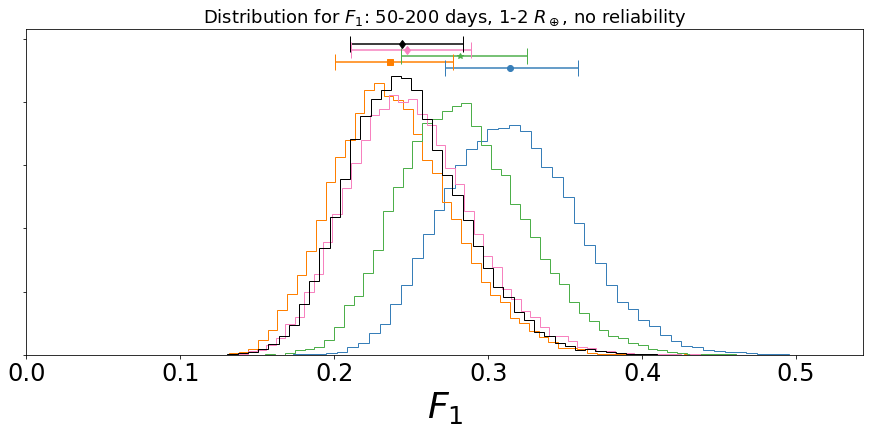

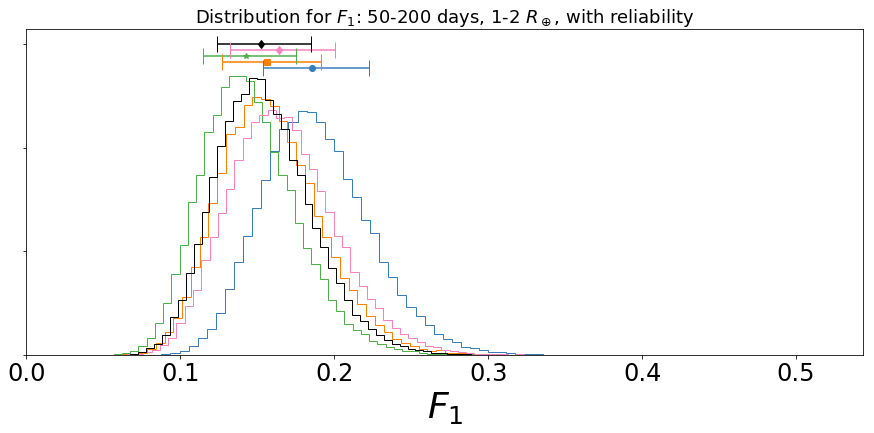

In [15]:
capsize = 8

plt.figure(figsize=(15,6));
xlim = plot_dists_and_errorbars(f1dists, 0, 0)
plt.xlabel(r"$F_1$", fontSize = 36);
plt.savefig("bootstrapComparison/f1DistNoReliability.pdf",bbox_inches='tight')
plt.title("Distribution for $F_1$: 50-200 days, 1-2 $R_\oplus$, no reliability", fontsize=18);


plt.figure(figsize=(15,6));
plot_dists_and_errorbars(f1dists, 1, [0, xlim[1]])
plt.xlabel(r"$F_1$", fontSize = 36);
plt.savefig("bootstrapComparison/f1DistWithReliability.pdf",bbox_inches='tight')
plt.title("Distribution for $F_1$: 50-200 days, 1-2 $R_\oplus$, with reliability", fontsize=18);


F_1 Without Reliability = 0.263^{+0.055}_{-0.044}
F_1 With Reliability = 0.160^{+0.038}_{-0.032}


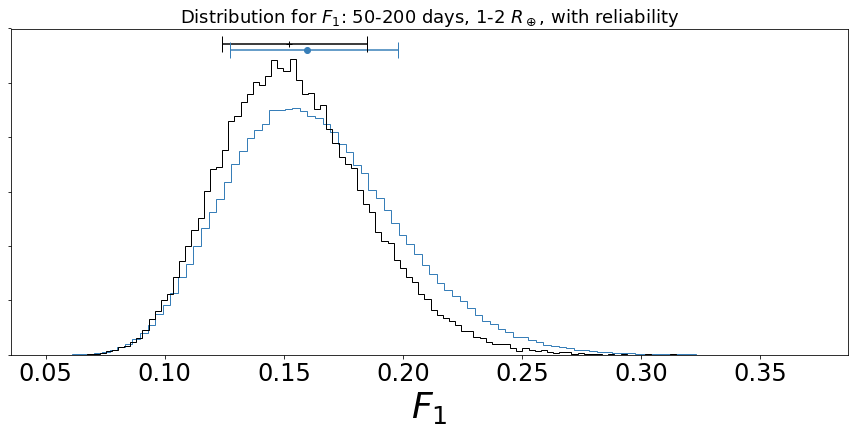

In [24]:
f1BootDistNR, f1BootDistWR = assemble_bootstrap_dists(f1dists)
print("F_1 Without Reliability = " + printMedianAndErrorbars(f1BootDistNR))
print("F_1 With Reliability = " + printMedianAndErrorbars(f1BootDistWR))

plt.figure(figsize=(15,6));
plt.hist(f1BootDistWR, 100, histtype="step", color=cbc[0], density=True);
plt.hist(f1dists[9], 100, histtype="step", color='k', density=True);
ylim = plt.ylim()

stats0 = medianAndErrorbars(f1BootDistWR)
plt.errorbar(stats0[0], 0.98*ylim[1], xerr=[[stats0[2]],[stats0[1]]], capsize = capsize, color = cbc[0], fmt='--o')
stats0 = medianAndErrorbars(f1dists[9])
plt.errorbar(stats0[0], 1.00*ylim[1], xerr=[[stats0[2]],[stats0[1]]], capsize = capsize, color = 'k', fmt='--+')
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel(r"$F_1$", fontSize = 36);
plt.savefig("bootstrapComparison/f1BootDistWithReliability.pdf",bbox_inches='tight')
plt.title("Distribution for $F_1$: 50-200 days, 1-2 $R_\oplus$, with reliability", fontsize=18);


In [17]:
zetaEarthPeriodRange = [.8*365.25,1.2*365.25];
zetaEarthRadiusRange = [0.8,1.2];


print("zeta_Earth:")

zetaEarthdists = integrateModels(zetaEarthPeriodRange, zetaEarthRadiusRange, model)


zeta_Earth:


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

High Box 1 Without Reliability = 0.149^{+0.057}_{-0.043}
High Box 1 With Reliability = 0.033^{+0.020}_{-0.013}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

Low Box 1 Without Reliability = 0.123^{+0.056}_{-0.040}
Low Box 1 With Reliability = 0.037^{+0.024}_{-0.015}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

High Box 2 Without Reliability = 0.100^{+0.043}_{-0.030}
High Box 2 With Reliability = 0.014^{+0.011}_{-0.007}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

Low Box 1 Without Reliability = 0.119^{+0.052}_{-0.038}
Low Box 1 With Reliability = 0.048^{+0.030}_{-0.020}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

fpwgpc baseline Without Reliability = 0.082^{+0.036}_{-0.025}
fpwgpc baseline With Reliability = 0.020^{+0.013}_{-0.008}


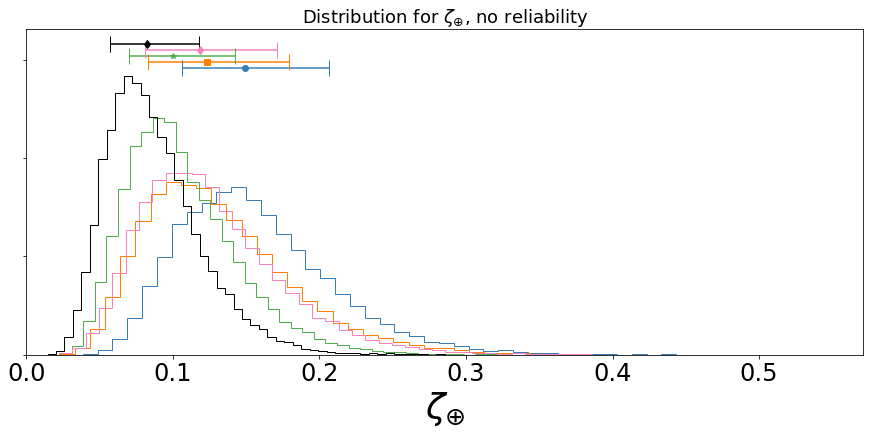

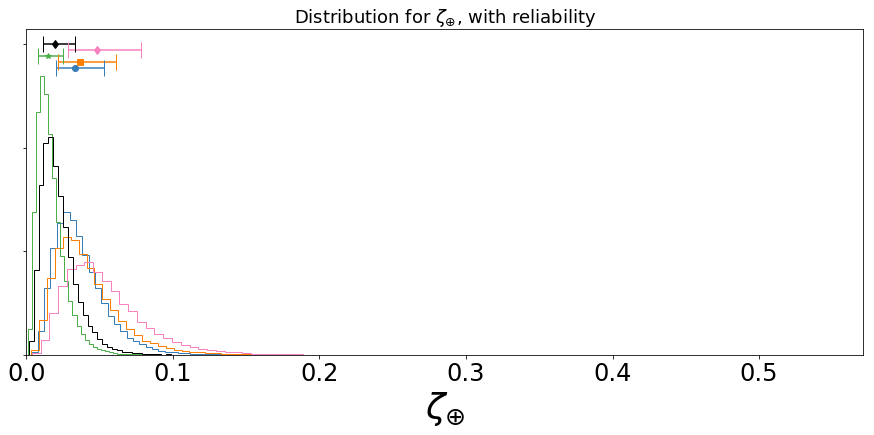

In [18]:
plt.figure(figsize=(15,6));
xlim = plot_dists_and_errorbars(zetaEarthdists, 0, 0)
plt.xlabel(r"$\zeta_{\oplus}$", fontSize = 36);
plt.savefig("bootstrapComparison/zetaEarthDistNoReliability.pdf",bbox_inches='tight')
plt.title("Distribution for $\zeta_{\oplus}$, no reliability", fontsize=18);


plt.figure(figsize=(15,6));
plot_dists_and_errorbars(zetaEarthdists, 1, [0, xlim[1]])
plt.xlabel(r"$\zeta_{\oplus}$", fontSize = 36);
plt.savefig("bootstrapComparison/zetaEarthDistWithReliability.pdf",bbox_inches='tight')
plt.title("Distribution for $\zeta_{\oplus}$, with reliability", fontsize=18);


Bootstrap zeta-Earth Without Reliability = 0.113^{+0.057}_{-0.039}
Bootstrap zeta-Earth With Reliability = 0.028^{+0.026}_{-0.015}


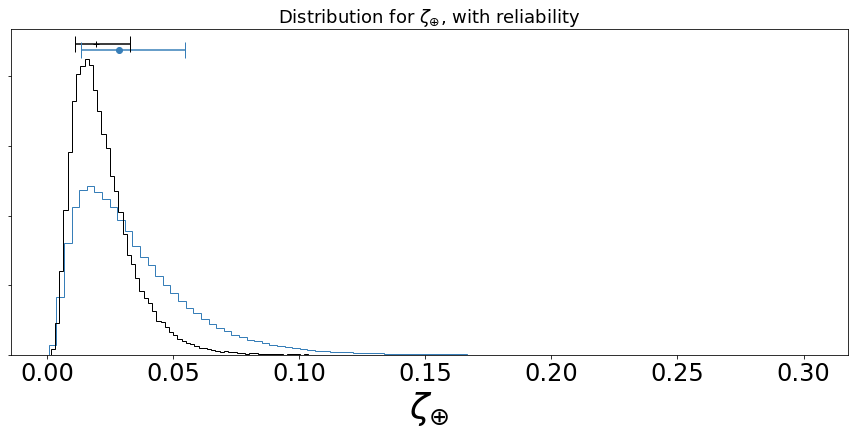

In [28]:
zetaEarthBootDistNR, zetaEarthBootDistWR = assemble_bootstrap_dists(zetaEarthdists)
print("Bootstrap zeta-Earth Without Reliability = " + printMedianAndErrorbars(zetaEarthBootDistNR))
print("Bootstrap zeta-Earth With Reliability = " + printMedianAndErrorbars(zetaEarthBootDistWR))

plt.figure(figsize=(15,6));
plt.hist(zetaEarthBootDistWR, 100, histtype="step", color=cbc[0], density=True);
plt.hist(zetaEarthdists[9], 100, histtype="step", color='k', density=True);
ylim = plt.ylim()

stats0 = medianAndErrorbars(zetaEarthBootDistWR)
plt.errorbar(stats0[0], 0.98*ylim[1], xerr=[[stats0[2]],[stats0[1]]], capsize = capsize, color = cbc[0], fmt='--o')
stats0 = medianAndErrorbars(zetaEarthdists[9])
plt.errorbar(stats0[0], 1.00*ylim[1], xerr=[[stats0[2]],[stats0[1]]], capsize = capsize, color = 'k', fmt='--+')
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel(r"$\zeta_{\oplus}$", fontSize = 36);
plt.savefig("bootstrapComparison/zetaEarthBootDistWithReliability.pdf",bbox_inches='tight')
plt.title("Distribution for $\zeta_{\oplus}$, with reliability", fontsize=18);


In [20]:
sag13etaEarthPeriodRange = [237,860];
sag13etaEarthRadiusRange = [0.5,1.5];


print("SAG13 eta_Earth:")

sag13dists = integrateModels(sag13etaEarthPeriodRange, sag13etaEarthRadiusRange, model)


SAG13 eta_Earth:


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

High Box 1 Without Reliability = 1.638^{+0.780}_{-0.540}
High Box 1 With Reliability = 0.294^{+0.200}_{-0.121}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

Low Box 1 Without Reliability = 1.391^{+0.801}_{-0.513}
Low Box 1 With Reliability = 0.340^{+0.271}_{-0.152}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

High Box 2 Without Reliability = 1.010^{+0.536}_{-0.338}
High Box 2 With Reliability = 0.117^{+0.096}_{-0.054}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

Low Box 1 Without Reliability = 1.305^{+0.739}_{-0.480}
Low Box 1 With Reliability = 0.466^{+0.356}_{-0.208}


FloatProgress(value=0.0, max=80000.0)

FloatProgress(value=0.0, max=60000.0)

fpwgpc baseline Without Reliability = 0.826^{+0.430}_{-0.281}
fpwgpc baseline With Reliability = 0.166^{+0.125}_{-0.072}


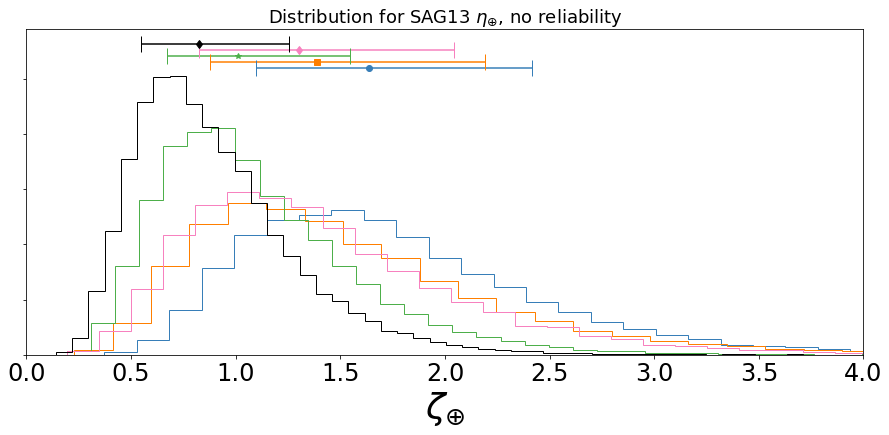

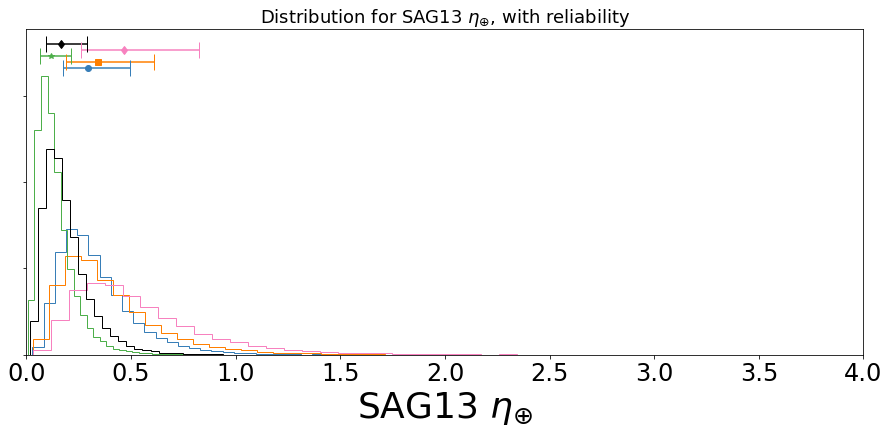

In [21]:
plt.figure(figsize=(15,6));
xlim = plot_dists_and_errorbars(sag13dists, 0, [0, 4])
plt.xlabel(r"$\zeta_{\oplus}$", fontSize = 36);
plt.savefig("bootstrapComparison/sag13etaEarthDistNoReliability.pdf",bbox_inches='tight')
plt.title("Distribution for SAG13 $\eta_{\oplus}$, no reliability", fontsize=18);

plt.figure(figsize=(15,6));
plot_dists_and_errorbars(sag13dists, 1, [0, 4])
plt.xlabel(r"SAG13 $\eta_{\oplus}$", fontSize = 36);
plt.savefig("bootstrapComparison/sag13etaEarthDistWithReliability.pdf",bbox_inches='tight')
plt.title("Distribution for SAG13 $\eta_{\oplus}$, with reliability", fontsize=18);


Bootstrap SAG 13 Eta-Earth Without Reliability = 1.203^{+0.766}_{-0.474}
Bootstrap SAG 13 Eta-Earth With Reliability = 0.251^{+0.278}_{-0.138}


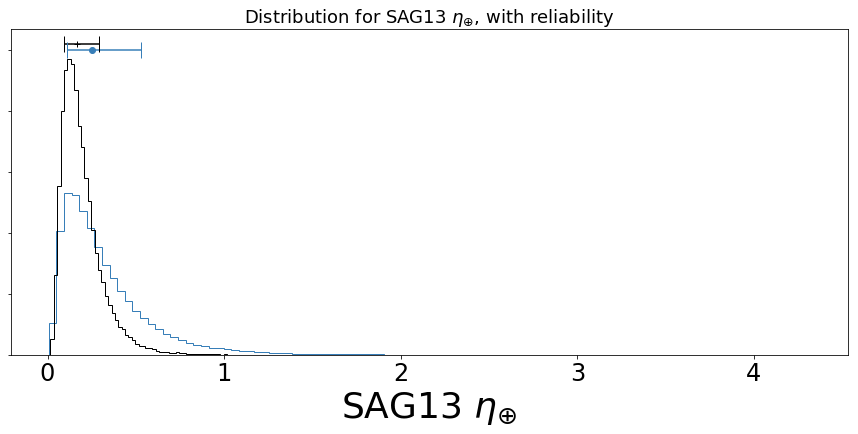

In [29]:
sag13BootDistNR, sag13BootDistWR = assemble_bootstrap_dists(sag13dists)
print("Bootstrap SAG 13 Eta-Earth Without Reliability = " + printMedianAndErrorbars(sag13BootDistNR))
print("Bootstrap SAG 13 Eta-Earth With Reliability = " + printMedianAndErrorbars(sag13BootDistWR))

plt.figure(figsize=(15,6));
plt.hist(sag13BootDistWR, 100, histtype="step", color=cbc[0], density=True);
plt.hist(sag13dists[9], 100, histtype="step", color='k', density=True);
ylim = plt.ylim()

stats0 = medianAndErrorbars(sag13BootDistWR)
plt.errorbar(stats0[0], 0.98*ylim[1], xerr=[[stats0[2]],[stats0[1]]], capsize = capsize, color = cbc[0], fmt='--o')
stats0 = medianAndErrorbars(sag13dists[9])
plt.errorbar(stats0[0], 1.00*ylim[1], xerr=[[stats0[2]],[stats0[1]]], capsize = capsize, color = 'k', fmt='--+')
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel(r"SAG13 $\eta_{\oplus}$", fontSize = 36);
plt.savefig("bootstrapComparison/sag13etaEarthBootDistWithReliability.pdf",bbox_inches='tight')
plt.title("Distribution for SAG13 $\eta_{\oplus}$, with reliability", fontsize=18);


In [33]:
np.percentile(sag13BootDistWR, 5)

0.06655239191403664

In [34]:
np.percentile(sag13BootDistWR, 95)

0.8272469199014597